In [1]:
from sklearn.metrics import fbeta_score, classification_report,f1_score
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

2025-05-25 13:51:08.644525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748181068.816585      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748181068.868479      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# datasets
labels = pd.read_csv("/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv")
sample = pd.read_csv('/kaggle/input/soil-classification/soil_classification-2025/sample_submission.csv')

# folders paths
train_path = "/kaggle/input/soil-classification/soil_classification-2025/train"
test_path = "/kaggle/input/soil-classification/soil_classification-2025/test"

In [3]:
labels.head()

,image_id,soil_type
0,img_ed005410.jpg,Alluvial soil
1,img_0c5ecd2a.jpg,Alluvial soil
2,img_ed713bb5.jpg,Alluvial soil
3,img_12c58874.jpg,Alluvial soil
4,img_eff357af.jpg,Alluvial soil


In [4]:
train_df, valid_df = train_test_split(
    labels,
    test_size=0.2,
    stratify=labels['soil_type'], 
    random_state=42
)
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                 )

train_generator = gen.flow_from_dataframe(
    train_df,
    directory = train_path,
    x_col = 'image_id',
    y_col = 'soil_type',
    color_mode="rgb",
    target_size = (331,331), 
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)


validation_generator = gen.flow_from_dataframe(
    valid_df,
    directory = train_path, 
    x_col = 'image_id',
    y_col = 'soil_type',
    color_mode="rgb",
    target_size = (331,331),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
    seed=42,
)

Found 970 validated image filenames belonging to 4 classes.
Found 244 validated image filenames belonging to 4 classes.


In [5]:
x,y = next(train_generator)
x.shape


(32, 331, 331, 3)

In [12]:
a = train_generator.class_indices
class_names = list(a.keys())  


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

NameError: name 'x' is not defined

In [5]:
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

base_model.trainable=False
input_tensor = tf.keras.Input(shape=(331,331,3))
output_tensor = base_model(input_tensor)
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(), 
        tf.keras.layers.Dense(512, activation='relu' ,kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

I0000 00:00:1748181082.874595      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748181082.875326      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 9, 9, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_203              │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,302,564 (210.96 MB)

 Trainable params: 962,756 (3.67 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

In [8]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [9]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                    callbacks=[early])

Epoch 1/20


I0000 00:00:1748181118.406598      96 service.cc:148] XLA service 0x7f13a4002070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748181118.407299      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748181118.407327      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748181123.312329      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748181137.510310      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5481 - loss: 1.1760 - val_accuracy: 0.7009 - val_loss: 0.8467
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.7500 - loss: 0.6402 - val_accuracy: 0.7411 - val_loss: 0.8244
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - accuracy: 0.8165 - loss: 0.5691 - val_accuracy: 0.9062 - val_loss: 0.5541
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8750 - loss: 0.3928 - val_accuracy: 0.9062 - val_loss: 0.5547
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 431ms/step - accuracy: 0.8833 - loss: 0.4195 - val_accuracy: 0.9241 - val_loss: 0.4473
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9062 - loss: 0.3020 - val_accuracy: 0.9241 - val_loss: 0.4377
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 437ms/step - accuracy: 0.9211 - loss: 0.3194 - val_accuracy: 0.9420 - val_loss: 0.3206
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 1.0000 - loss: 0.1112 - val_accuracy: 0.9375 - val_

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model_architecture.png", show_shapes=True, dpi=96)

In [10]:
model.save("soil_model.h5")

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: \n          0.90625\nValidation Accuracy: 0.96875')

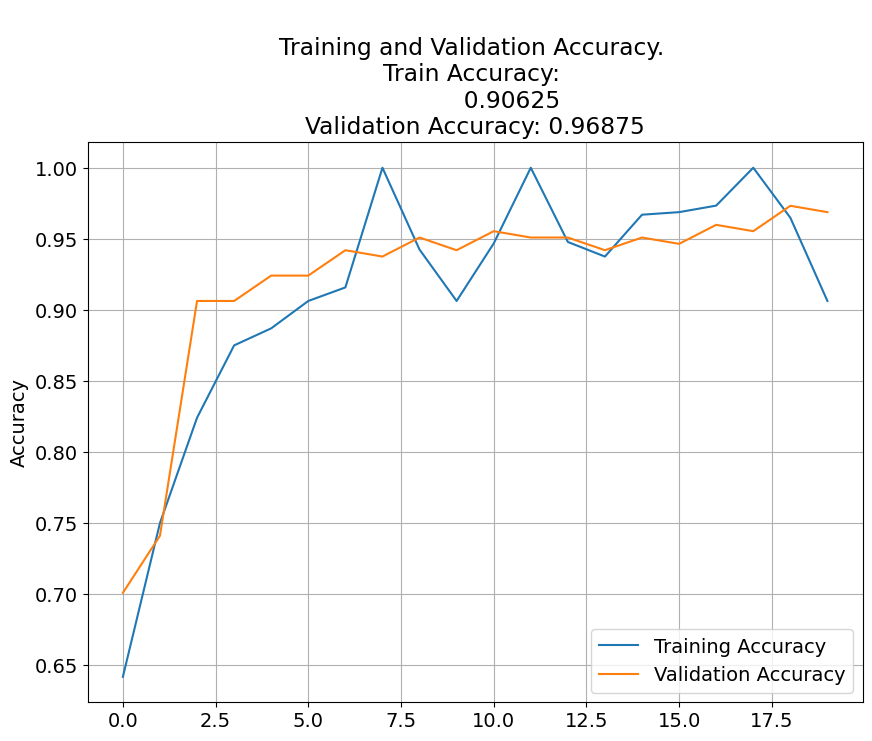

In [13]:
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f"""\nTraining and Validation Accuracy. \nTrain Accuracy: 
          {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}""")

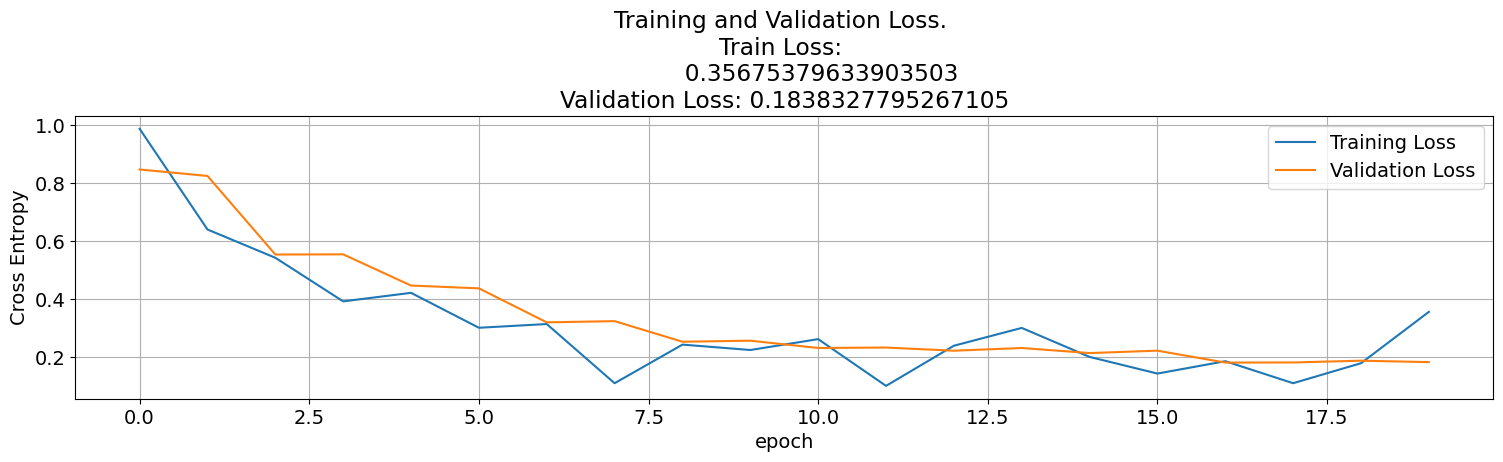

In [14]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f"""Training and Validation Loss. \nTrain Loss: 
          {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}""")
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [15]:
accuracy_score = model.evaluate(validation_generator)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))


8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9562 - loss: 0.1948 
Accuracy: 95.4918%


In [16]:
print("Loss: ",accuracy_score[0])

Loss:  0.21142999827861786


In [17]:
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes           
f1_scores = f1_score(y_true, y_pred, average=None)
f2_scores = fbeta_score(y_true, y_pred, beta=2, average=None)

class_labels = list(validation_generator.class_indices.keys())
for i, label in enumerate(class_labels):
    print(f"Class '{label}': F1 Score = {f1_scores[i]:.4f}, F2 Score = {f2_scores[i]:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step 
Class 'Alluvial soil': F1 Score = 0.9565, F2 Score = 0.9429
Class 'Black Soil': F1 Score = 0.9556, F2 Score = 0.9556
Class 'Clay soil': F1 Score = 0.9639, F2 Score = 0.9852
Class 'Red soil': F1 Score = 0.9630, F2 Score = 0.9738


In [18]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))



Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.98      0.93      0.96       106
   Black Soil       0.96      0.96      0.96        45
    Clay soil       0.93      1.00      0.96        40
     Red soil       0.95      0.98      0.96        53

     accuracy                           0.96       244
    macro avg       0.95      0.97      0.96       244
 weighted avg       0.96      0.96      0.96       244



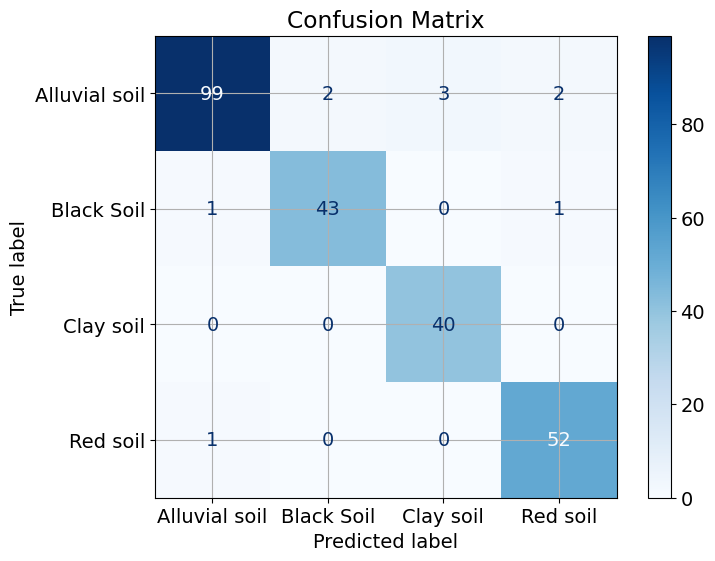

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
predictions = []
test_images = os.listdir(test_path)
for image in test_images:
    img_path = os.path.join(test_path, image)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(331, 331))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
    img = tf.reshape(img, (-1, 331, 331, 3))
    prediction = model.predict(img/255)
    class_index = np.argmax(prediction)
    class_name = class_labels[class_index] 
    predictions.append(class_name)

In [ ]:
my_submission = pd.DataFrame({'image_id': test_images, 'soil_type':  predictions})
my_submission.to_csv('submission.csv', index=False)